In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os

train_path = "/content/drive/MyDrive/DeepLearningDa/train.csv"
test_path = "/content/drive/MyDrive/DeepLearningDa/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
def upper_rate(t):
    return len([i for i in t if i.isupper()]) / len(t)

def digits_rate(t):
    return len([i for i in t if i.isdigit()]) / len(t)

def how_many(t, c):
    return len(t) - len(t.replace(c, ''))
    
def word_len(t):
    for sign in ' .:!?,/|':
        t = t.replace(sign, ' ')
    prepared = t.replace('  ', ' ')
    cnt = len(prepared.split(' '))
    total = len(prepared.replace(' ', ''))
    return cnt / total


def extract_feature(name, func, col_from='text'):
    train[name] = train[col_from].apply(func)
    test[name] = test[col_from].apply(func)

extract_feature('text_len', lambda t: len(t))
extract_feature('urls', lambda t: how_many(t, 'http'))
extract_feature('upper_rate', upper_rate)
extract_feature('digits', digits_rate)
extract_feature('has_location', lambda l: 1 if l == l else 0, col_from='location')
extract_feature('has_keyword', lambda l: 1 if l == l else 0, col_from='keyword')

signs = '.,-|/:;+=#[](){}<>?!@$%^&*_"~' + "'"
for sign in signs:
    extract_feature('sign_' + sign, lambda t: how_many(t, sign))

def clean_text(t):
    for s in sign:
        t = t.replace(s, ' ')
    for i in '1234567890':
        t = t.replace(i, '')
    t = t.replace('https', '')
    t = t.replace('http', '')
    t = t.replace('  ', ' ')
    t = t.lower()
    return t

extract_feature('text', clean_text)

cols = ['text_len', 'urls', 'upper_rate', 'digits', 'has_location', 'has_keyword'] + ['sign_' + i for i in signs]

train.head()

,id,keyword,location,text,target,text_len,urls,upper_rate,digits,has_location,...,sign_@,sign_$,sign_%,sign_^,sign_&,sign_*,sign__,"sign_""",sign_~,sign_'
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,69,0,0.144928,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,38,0,0.131579,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,133,0,0.015038,0.000000,0,...,0,0,0,0,0,0,0,0,0,2
3,6,NaN,NaN,", people receive #wildfires evacuation orders ...",1,65,0,0.015385,0.076923,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,88,0,0.034091,0.000000,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.decomposition import PCA

cols = ['text_len', 'urls', 'upper_rate', 'digits', 'has_location', 'has_keyword'] + ['sign_' + i for i in signs]

label = train['target'].to_numpy()
test_ids = test['id'].to_numpy()

maxLen = max([len(i) for i in train['text']])
print('Max length =', maxLen)

pcaTrain = train[cols]
pcaTest = test[cols]


print(pcaTrain)

pca = PCA(0.999)
pca.fit(pcaTrain)

pcaTrain = pca.transform(pcaTrain)
pcaTest = pca.transform(pcaTest)

train.drop(columns=['id', 'keyword', 'location', 'target'] + cols, inplace=True)
test.drop(columns=['id', 'keyword', 'location'] + cols, inplace=True)

train.shape, pcaTrain.shape, test.shape, pcaTest.shape, label.shape
train.head()


Max length = 156
      text_len  urls  upper_rate    digits  has_location  has_keyword  sign_.  \
0           69     0    0.144928  0.000000             0            0       0   
1           38     0    0.131579  0.000000             0            0       1   
2          133     0    0.015038  0.000000             0            0       1   
3           65     0    0.015385  0.076923             0            0       0   
4           88     0    0.034091  0.000000             0            0       0   
...        ...   ...         ...       ...           ...          ...     ...   
7608        83     4    0.084337  0.012048             0            0       1   
7609       125     0    0.048000  0.000000             0            0       2   
7610        65     4    0.153846  0.138462             0            0       3   
7611       137     0    0.029197  0.000000             0            0       2   
7612        94     4    0.170213  0.021277             0            0       1   

      sign

,text
0,our deeds are the reason of this #earthquake m...
1,forest fire near la ronge sask. canada
2,all residents asked to shelter in place are be...
3,", people receive #wildfires evacuation orders ..."
4,just got sent this photo from ruby #alaska as ...


In [6]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxWords = 20000

#Creating Word Vectors
tk = Tokenizer(num_words=maxWords)
corpus = [text for text in train['text']]
tk.fit_on_texts(corpus)

#Convert text into vectors 
train_sequences = tk.texts_to_sequences(train['text'])
test_sequences = tk.texts_to_sequences(test['text'])
word_indexes = tk.word_index

#Convert tweets into vectors
x_train = pad_sequences(train_sequences, maxlen=maxLen)
x_test = pad_sequences(test_sequences, maxlen=maxLen)

#Extend it with extras
x_train = np.concatenate([x_train, pcaTrain], axis=1)
x_test = np.concatenate([x_test, pcaTest], axis=1)

x_train.shape, x_test.shape

((7613, 166), (3263, 166))

In [8]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# split train into train and validation data
x_train, x_train_val, label, target_val = train_test_split(x_train, label, test_size=0.2, random_state=42)

x_train.shape, label.shape, x_train_val.shape, target_val.shape

((4872, 166), (4872,), (1218, 166), (1218,))

In [9]:
from tqdm.notebook import tqdm
# GloVe dimension
dim = 100

embeddings = {}
gloveFile = open('/content/drive/MyDrive/glove.6B.100d.txt', 'r')
for line in tqdm(gloveFile, total=400000):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
gloveFile.close()

# weights matrix for embedded layer
embedding_matrix = np.zeros((maxWords, dim))
for word, i in word_indexes.items():
    if i < maxWords:
        emb_vec = embeddings.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
embedding_matrix

  0%|          | 0/400000 [00:00<?, ?it/s]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13482   ,  0.40224001, -0.42265999, ..., -0.27989   ,
         0.28937   ,  0.043783  ],
       [ 0.23182   , -0.35374001, -0.067178  , ..., -0.34251001,
         0.87474   ,  0.12929   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.25224999, -0.84336001, -0.20193   , ...,  0.64832002,
         0.0054213 ,  0.32846001],
       [ 0.35187   , -0.54909998,  0.44606   , ..., -0.71447003,
        -0.40821999,  0.058208  ]])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 extra (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 glove (InputLayer)             [(None, 156)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            88          ['extra[0][0]']                  
                                                                                                  
 embedding (Embedding)          (None, 156, 100)     2000000     ['glove[0][0]']                  
                                                                                              

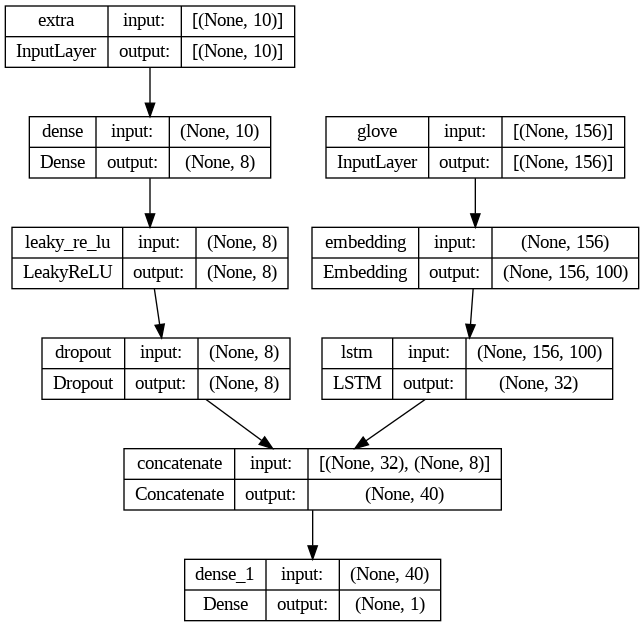

In [10]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Flatten, Bidirectional, concatenate, LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model
from keras import Input
from keras.utils import plot_model
from keras.regularizers import l2
from keras import backend as K

def calcRecall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def calcPrecision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1Score(y_true, y_pred):
    precision = calcPrecision(y_true, y_pred)
    recall = calcRecall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():
    
    #Glove branch
    emb_input = Input(shape=(maxLen, ), name='glove')
    emb_x = Embedding(maxWords, dim, input_length=maxLen, weights=[embedding_matrix], trainable=False)(emb_input)
    emb_x = LSTM(32, activation='elu', dropout=0.2, recurrent_dropout=0.2)(emb_x)
    
    # extra features branch
    ex_input = Input(shape=(pcaTrain.shape[1], ), name='extra')
    ex_x = Dense(8)(ex_input)
    ex_x = LeakyReLU()(
        
        
        ex_x)
    ex_x = Dropout(0.5)(ex_x)
    
    out = Dense(1, activation='sigmoid')(concatenate([emb_x, ex_x]))
    
    model = Model(inputs=[emb_input, ex_input], outputs=out)

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[f1Score]
    )
    return model

lstm = create_model()
lstm.summary()
plot_model(lstm, show_shapes=True, to_file='model.png')

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(pcaTrain)

def create_x_dict(x_train):
    return {
        'glove': x_train[:, :-pcaTrain.shape[1]],
        'extra': scaler.transform(x_train[:, -pcaTrain.shape[1]:])
    }
    
x_train_local, target_local = create_x_dict(x_train), label
x_val_local, target_val_local = create_x_dict(x_train_val), target_val

es = EarlyStopping(patience=17, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(patience=5, verbose=1)

model = create_model()
history = model.fit(
    x_train_local,
    target_local,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[es, rlr],
    validation_data=(x_val_local, target_val_local)
)

Epoch 1/10
153/153 [==============================] - 38s 222ms/step - loss: 0.5625 - f1Score: 0.6406 - val_loss: 0.4596 - val_f1Score: 0.7513 - lr: 0.0010
Epoch 2/10
153/153 [==============================] - 36s 236ms/step - loss: 0.4636 - f1Score: 0.7231 - val_loss: 0.4363 - val_f1Score: 0.7420 - lr: 0.0010
Epoch 3/10
153/153 [==============================] - 33s 216ms/step - loss: 0.4460 - f1Score: 0.7348 - val_loss: 0.4246 - val_f1Score: 0.7590 - lr: 0.0010
Epoch 4/10
153/153 [==============================] - 33s 216ms/step - loss: 0.4252 - f1Score: 0.7524 - val_loss: 0.4287 - val_f1Score: 0.7681 - lr: 0.0010
Epoch 5/10
153/153 [==============================] - 33s 217ms/step - loss: 0.4211 - f1Score: 0.7532 - val_loss: 0.4160 - val_f1Score: 0.7737 - lr: 0.0010
Epoch 6/10
153/153 [==============================] - 35s 228ms/step - loss: 0.4132 - f1Score: 0.7656 - val_loss: 0.4257 - val_f1Score: 0.7506 - lr: 0.0010
Epoch 7/10
153/153 [==============================] - 33s 216ms/

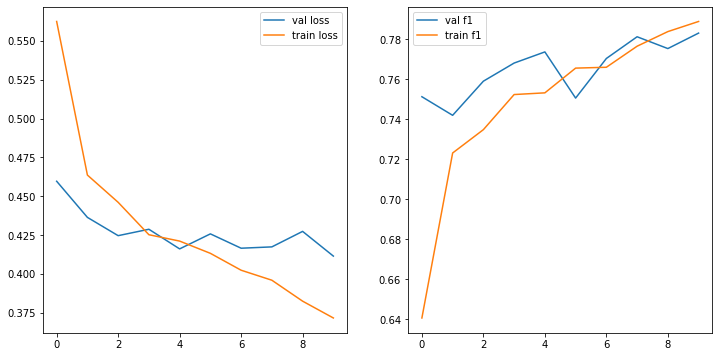

In [12]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(12, 6))

plt.subplot(121)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['val_f1Score'], label='val f1')
plt.plot(history.history['f1Score'], label='train f1')
plt.legend()

plt.show()

In [13]:
predict = model.predict(create_x_dict(x_test)).flatten()
predict[predict > 0.5] = 1
predict[predict != 1] = 0
predict = predict.round().astype(int)
disaster = predict.sum() / predict.shape[0]
disaster

102/102 [==============================] - 3s 28ms/step


0.3784860557768924

In [17]:
print("Validation Accuracy : ",history.history['val_f1Score'][-1]*100)

Validation Accuracy :  78.30932140350342
